# Libraries

In [258]:
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.interpolate import splprep, splev
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from pathlib import Path

%config InlineBackend.figure_formats=['retina']

In [259]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

from stabl.stabl import Stabl, plot_stabl_path
from stabl.preprocessing import remove_low_info_samples, LowInfoFilter
from stabl.visualization import boxplot_features

# Data

In [260]:
cell_pops = ['Bcells','CCR2nncMC', 'CCR2pcMC', 'CD41hiCD61hiPLT', 'CD4Tcm',
                        'CD4Tem', 'CD4Tnaive', 'CD4Trm', 'Tregnaive', 'Tregmem', 'Th1mem', 'Th1naive',
                        'CD8Trm', 'gdTcells', 'intMC', 'mDC', 'MDSC', 'NKT', 'pDC',
                        'CD62LpImmatureNeutrophils', 'CD8Tcm', 'CD8Tem', 'CD8Tnaive',
                        'CD61pCD41pPLT', 'CD62LnAgedNeutrophils', 'CD56brightCD16nNKcells', 'CD56dimCD16pNKcells']
times = ['Delta', 'P1', 'P2', 'P3']


In [261]:
dict_tot = {}
for time in times:
    dict_tot[time] = pd.DataFrame()
    dict_tot[time+'_unstim'] = pd.DataFrame()
    for cellpop in cell_pops:
        if time != 'Delta' or cellpop != 'NKT':
            X = pd.read_csv(Path('./Data', time, cellpop, 'X.csv'), index_col=0)
            X.columns = [cellpop + '_' + el for el in X.columns]
            dict_tot[time +'_unstim'] = pd.concat([dict_tot[time +'_unstim'] ,X], axis=1)
            X.index = [str(idx) + '_' + time for idx in X.index]
            dict_tot[time] = pd.concat([dict_tot[time] ,X], axis=1)
    y = pd.read_csv(Path('./Data', time, cellpop, 'y.csv'), index_col=0)
    #y.index = [str(idx) + '_' + time for idx in y.index]
    y.columns = ['label']
    dict_tot['y' + time] = y
        

In [262]:
df_tot = pd.concat([dict_tot[time] for time in times], axis='rows')

#df_tot = pd.concat([dict_tot[time] for time in ['P2']], axis='columns')

In [263]:
df_tot.shape

(80, 322)

# ANOVA

In [264]:
X_P1 = dict_tot['P1_unstim'].join(dict_tot['yP1'])
X_P1['TimePoint'] = 1
X_P2 = dict_tot['P2_unstim'].join(dict_tot['yP2'])
X_P2['TimePoint'] = 2
X_P3 = dict_tot['P3_unstim'].join(dict_tot['yP3'])
X_P3['TimePoint'] = 3
X_Delta = dict_tot['Delta_unstim'].join(dict_tot['yDelta'])
X_Delta['TimePoint'] = 4

In [313]:
df_anova = pd.concat([X_Delta],axis='rows').dropna(subset=['label']).reset_index(drop=True)
df_anova.fillna(df_anova.median(), inplace=True)


In [314]:
df_anova['label'] = df_anova.label.astype(int)

In [315]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
pvalues_anova = pd.DataFrame(index = df_anova.columns)
for feature in df_anova.columns:
    # Ordinary Least Squares (OLS) model
    model = ols(f'{feature} ~ C(label)*C(TimePoint)', data=df_anova).fit()
    table = sm.stats.anova_lm(model,typ=1)
    pvalues_anova.loc[feature,'pvalue_anova']=table.loc['C(label)', 'PR(>F)']

> model = ols(f'{feature} ~ C(label)*C(TimePoint)', data=df_anova).fit() 

This line of code is using the OLS (ordinary least squares) function from the statsmodels library in Python to perform a two-way ANOVA (analysis of variance) with interaction.

The dependent variable (or label) is being regressed on two categorical independent variables: TimePoint and label. The independent variables are being specified as factors using the C() function.

The * symbol is used to indicate an interaction effect between TimePoint and label. This means that the effect of TimePoint on the dependent variable depends on the level of label, and vice versa.

The 'feature' variable is the name of the dependent variable being analyzed, and 'df_anova' is the name of the data frame containing the data to be analyzed. The fit() method is called on the OLS model object to fit the model to the data and obtain the regression coefficients.

> model.params

Intercept                            0.103080

C(label)[T.1]                      0.066406

C(TimePoint)[T.2]                    0.075700

C(TimePoint)[T.3]                    0.014623

C(TimePoint)[T.4]                   -0.027380

C(label)[T.1]:C(TimePoint)[T.2]   -0.086079

C(label)[T.1]:C(TimePoint)[T.3]   -0.052524

C(label)[T.1]:C(TimePoint)[T.4]   -0.152485

dtype: float64


y = 0.103080 + 0.066406C(label) + 0.075700C(TimePoint_2) + 0.014623C(TimePoint_3) - 0.027380C(TimePoint_4) - 0.086079*C(label)C(TimePoint_2) - 0.052524C(label)C(TimePoint_3) - 0.152485C(label)*C(TimePoint_4)

In this formula, you would substitute the actual values of label and TimePoint for each observation in your dataset to obtain the predicted value of the dependent variable for that observation.

> table = sm.stats.anova_lm(model,typ=1)

Create Anova Table : https://www.itl.nist.gov/div898/handbook/prc/section4/prc433.htm#:~:text=The%20ANOVA%20table%20also%20shows,hypotheses%20about%20the%20population%20means.&text=When%20the%20null%20hypothesis%20of,be%20of%20approximately%20equal%20magnitude.

> pvalues_anova.loc[feature,'pvalue_anova']=table.loc['C(label)', 'PR(>F)']

Simply gets the p-value associated with the feature selected.

In [316]:
pvalues_anova = pvalues_anova.fillna(1)

# t-SNE

In [269]:
df_corr = df_tot.corr()

In [270]:
tsne = TSNE(learning_rate='auto', random_state=4).fit(df_tot.fillna(df_tot.median()).T)
df_tsne = pd.DataFrame(data=tsne.embedding_, index = df_tot.columns, columns = ['coor1', 'coor2'])

> How to chose the number of clusters ?

Gap Statistic

The gap statistic was developed by Stanford researchers Tibshirani, Walther and Hastie in their 2001 paper. The idea behind their approach was to find a way to compare cluster compactness with a null reference distribution of the data, i.e. a distribution with no obvious clustering. Their estimate for the optimal number of clusters is the value for which cluster compactness on the original data falls the farthest below this reference curve. This information is contained in the following formula for the gap statistic:


$$
Gap_n(k) = E_n^*(logW_k) - logW_k
$$

where Wk is measure of the compactness of our clustering based on the Within-Cluster-Sum of Squared Errors (WSS):

$$
D_k = \sum_{x_i \in C_k}\sum_{x_j \in C_k}{||x_i - x_j||^2} = 2n_k\sum_{x_i \in C_k}{||x_i - \mu_k||^2}
$$

Within-Cluster-Sum of Squared Errors is calculated by the inertia_ attribute of KMeans function as follows:

The square of the distance of each point from the centre of the cluster (Squared Errors)
The WSS score is the sum of these Squared Errors for all the points
Calculating gap statistic in python for k means clustering involves the following steps:

Cluster the observed data on various number of clusters and compute compactness of our clustering
Generate reference data sets and cluster each of them with varying number of clusters. The reference datasets are created from a “continuous uniform” distribution using the random_sample function.
Calculate average of compactness of our clustering on reference datasets
Calculate gap statistics as difference in compactness between clustering on reference data and original data

In [271]:
# # Gap Statistic for K means
# def optimalK(data, nrefs=3, maxClusters=15):
#     """
#     Calculates KMeans optimal K using Gap Statistic 
#     Params:
#         data: ndarry of shape (n_samples, n_features)
#         nrefs: number of sample reference datasets to create
#         maxClusters: Maximum number of clusters to test for
#     Returns: (gaps, optimalK)
#     """
#     gaps = np.zeros((len(range(1, maxClusters)),))
#     resultsdf = {'clusterCount':[], 'gap':[]}
#     for gap_index, k in enumerate(range(1, maxClusters)):
# # Holder for reference dispersion results
#         refDisps = np.zeros(nrefs)
# # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
#         for i in range(nrefs):
            
#             # Create new random reference set
#             randomReference = np.random.random_sample(size=data.shape)
            
#             # Fit to it
#             km = KMeans(n_clusters=k, n_init=100, random_state=42, init='k-means++')
#             km.fit(randomReference)
            
#             refDisp = km.inertia_
#             refDisps[i] = refDisp
# # Fit cluster to original data and create dispersion
#         km = KMeans(k)
#         km.fit(data)
        
#         origDisp = km.inertia_
# # Calculate gap statistic
#         gap = np.log(np.mean(refDisps)) - np.log(origDisp)
# # Assign this loop's gap statistic to gaps
#         gaps[gap_index] = gap
        
#         resultsdf['clusterCount'].append(k)
#         resultsdf['gap'].append(gap)
#     return (gaps.argmax() + 1, pd.DataFrame(resultsdf))

# score_g, df = optimalK(df_tsne[['coor1', 'coor2']], nrefs=5, maxClusters=15)
# plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b')
# plt.xlabel('K')
# plt.ylabel('Gap Statistic')
# plt.title('Gap Statistic vs. K')

In [272]:
clusterer = KMeans(n_clusters=9, n_init=100, random_state=42, init='k-means++')
cluster_labels = clusterer.fit_predict(df_tsne[['coor1', 'coor2']])
cen_x, cen_y = clusterer.cluster_centers_.T
df_tsne['cluster'] = cluster_labels

In [273]:
df_tsne = pd.concat([df_tsne, pvalues_anova], axis='columns')

# UMAP

In [274]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()#
scaler.fit(df_tot.fillna(df_tot.median()).T)

#Umap = UMAP(n_neighbors=20, n_components=2, metric='euclidean', min_dist=0.1, spread=1.0).fit_transform(df_tot.fillna(df_tot.median()).T)
Umap = UMAP(n_neighbors=20, n_components=2, metric='euclidean', min_dist=0.1, spread=1.0).fit_transform(scaler.transform(df_tot.fillna(df_tot.median()).T))
df_umap = pd.DataFrame(data=Umap, index = df_tot.columns, columns = ['coor1', 'coor2'])

In [275]:
# score_g, df = optimalK(df_umap[['coor1', 'coor2']], nrefs=5, maxClusters=20)
# plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b')
# plt.xlabel('K')
# plt.ylabel('Gap Statistic')
# plt.title('Gap Statistic vs. K')

In [276]:
clusterer_umap = KMeans(n_clusters=8, n_init=100, random_state=42, init='k-means++')
cluster_labels_umap = clusterer_umap.fit_predict(df_umap[['coor1', 'coor2']])
cen_x_umap, cen_y_umap = clusterer_umap.cluster_centers_.T
df_umap['cluster'] = cluster_labels_umap

In [277]:
df_umap = pd.concat([df_umap, pvalues_anova], axis='columns')

# Correlation Plot

In [294]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = [(1, 0, 0), (.7, .4, 0), (0, 0, 1)]  # R -> G -> B
colors = [(0,(0, 0, 1)),(.35,(227/256, 163/256, 103/256)),(.65,(227/256, 163/256, 103/256)), (1,(1, 0, 0))]
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom_cmp'

cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256,gamma=1)

In [295]:
# #with TSNE
# from adjustText import adjust_text
# from matplotlib import colors

# CORR_THRESH = 0.7
# TIMESTAMP = 'P1'
# #sizes_source = 'pvalue_'+TIMESTAMP
# sizes_source = 'pvalue_anova'
# #colors_source = 'effect_dir_'+TIMESTAMP

# SIZES = []
# for value in df_tsne[sizes_source].astype(float):
#     if value > 0.05:
#         SIZES.append(5.)
#     else:
#         SIZES.append(2*(-np.log10(value)*6)**2)

# SIZES = np.array(SIZES)

# def transform_to_color(i):
#     if i < np.inf:
#         return 'C' + str(int(i))
#     else:
#         return 'white'

# COLORS = [transform_to_color(i) for i in df_tsne.cluster]

# # --DRAWING CLUSTERS--
# fig, ax = plt.subplots(figsize=(11, 11))

# for i in np.unique(cluster_labels):
#     points = df_tsne[df_tsne.cluster == i][['coor1', 'coor2']].values
#     # get convex hull
#     hull = ConvexHull(points)
#     # get x and y coordinates
#     # repeat last point to close the polygon
#     x_hull = np.append(points[hull.vertices,0],
#                        points[hull.vertices,0][0])
#     y_hull = np.append(points[hull.vertices,1],
#                        points[hull.vertices,1][0])
    
#     tck, _ = splprep([x_hull, y_hull], s=0, per = True)
#     xx, yy = splev(np.linspace(0, 1, 100), tck, der = 0)
    
#     # plot shape
#     plt.fill(xx, yy, alpha=.1, color='C'+str(i)) #, label=f'Cluster {i}'
    
# # --DRAWING POINTS A FEW POINTS TO CREATE THE LEGENDS FOR PVALUES--
# scatter = plt.scatter(df_tsne.coor1[:100],
#                      df_tsne.coor2[:100],
#                      s=SIZES[:100], 
#                      marker='o', 
#                      c=COLORS[:100],
#                      norm=colors.CenteredNorm(),
#                      edgecolors=None,
#                      cmap=cmap,
#                      alpha=.7
#                     )

# def funct(s):
#     to_ret=np.zeros(len(s))
#     for idx, el in enumerate(s):
#         if el==5:
#             to_ret[idx] = 1
#         else:
#             to_ret[idx] = np.exp(np.log(10)*(-((el/2)**(1/2))/6))
#     return to_ret

# # kw = dict(prop="sizes", num=[0, .1, .2], color='gray', fmt="{x:.2f}",
# #            func=lambda s: np.sqrt(s)/75 - 0.01)£

# kw = dict(prop="sizes", num=[1, 0.05, 0.01, 0.001], color='gray', func=funct)
# legend = ax.legend(*scatter.legend_elements(**kw), loc="upper right", title="ANOVA pvalue",labelspacing=2, frameon=False)

# # --DRAWING ALL THE POINTS--
# scatter = plt.scatter(df_tsne.coor1,
#                      df_tsne.coor2, 
#                      s=SIZES, 
#                      marker='o', 
#                      c=COLORS,
#                      norm=colors.CenteredNorm(),
#                      edgecolors=None,
#                      cmap=cmap,
#                      alpha=.7
#                     )

# ax.axis("off")

# # fig.colorbar(scatter,
# #              anchor=(0,0),
# #              ax=ax, 
# #              shrink=.2, 
# #              label='Effect direction', 
# #              aspect=10, 
# #              use_gridspec=True,
# #              location='left')

# for i in df_tot.columns:
#     for j in df_tot.columns:
#         if df_corr.loc[i,j]>=CORR_THRESH and df_corr.loc[i,j] < 1:
#             sub_df = df_tsne.loc[[i, j]]
#             ax.plot(sub_df.coor1, sub_df.coor2, linewidth=.2,color='gray', alpha=.05)


# annot=[]        
# for i, txt in enumerate(df_tsne.index):
#     if df_tsne.iloc[i][sizes_source] <= 0.01:
#         annot.append(ax.annotate(txt, (df_tsne.iloc[i].coor1, df_tsne.iloc[i].coor2), fontsize=12))

# adjust_text(annot)

/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_75545/2035044407.py:50: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter = plt.scatter(#df_tsne.coor1[:100],
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_75545/2035044407.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter = plt.scatter(df_umap.coor1,


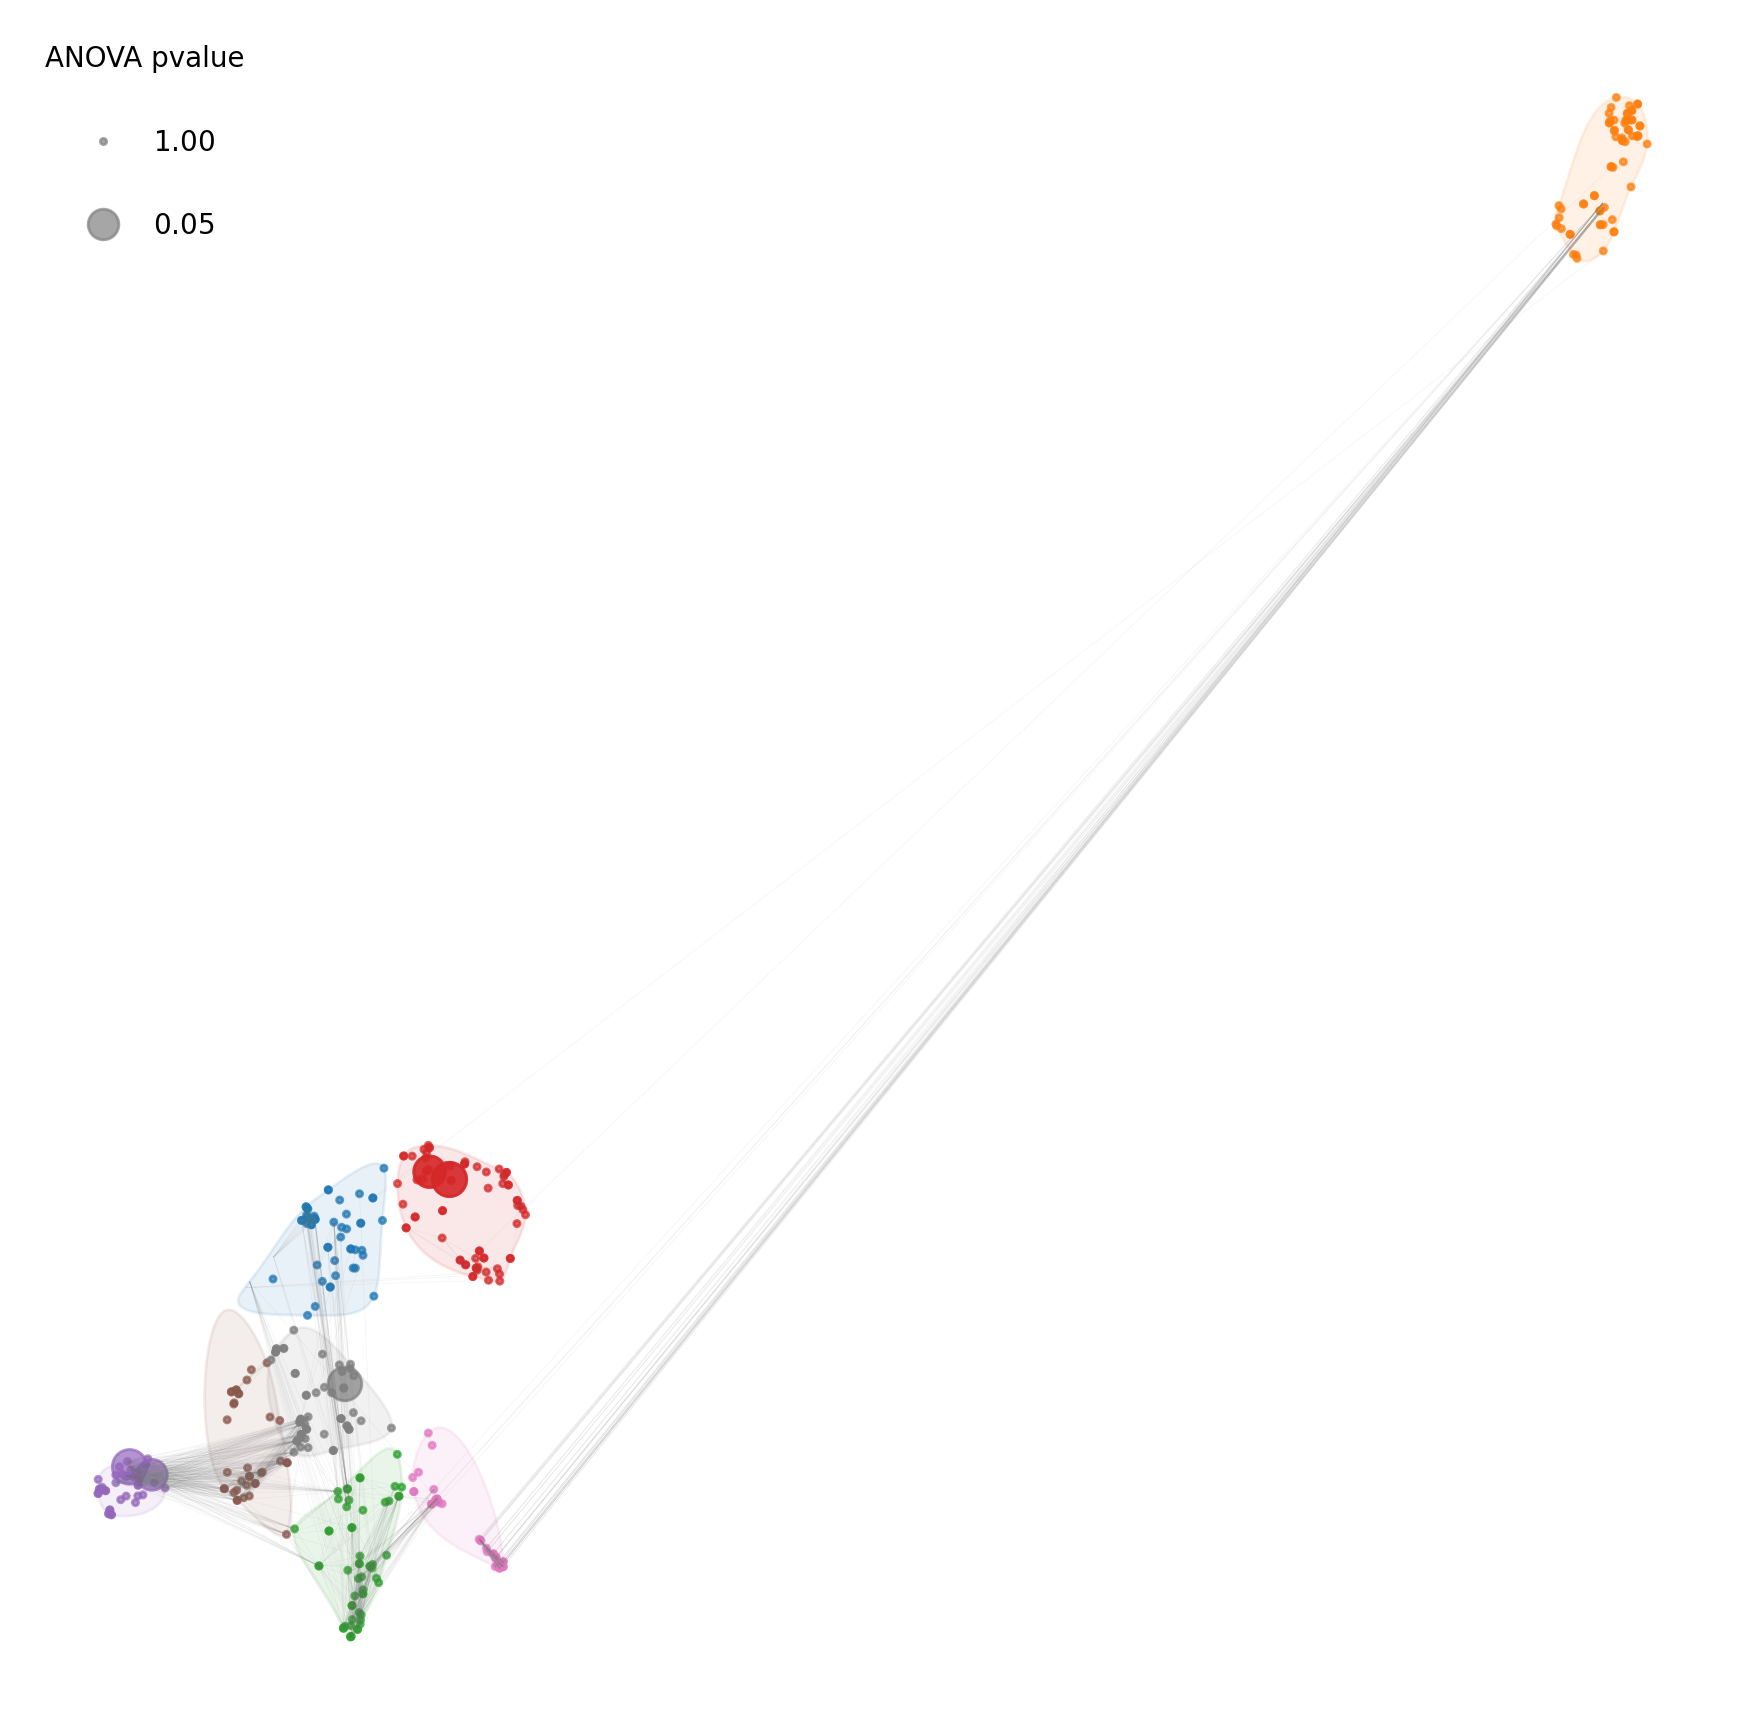

In [320]:
## with UMAP

from adjustText import adjust_text
from matplotlib import colors

CORR_THRESH = 0.9
TIMESTAMP = 'P1'
#sizes_source = 'pvalue_'+TIMESTAMP
sizes_source = 'pvalue_anova'
#colors_source = 'effect_dir_'+TIMESTAMP

SIZES = []
for value in df_umap[sizes_source].astype(float):
    if value > 0.05:
        SIZES.append(5.)
    else:
        SIZES.append(2*(-np.log10(value)*6)**2)

SIZES = np.array(SIZES)

def transform_to_color(i):
    if i < np.inf:
        return 'C' + str(int(i))
    else:
        return 'white'

COLORS = [transform_to_color(i) for i in df_umap.cluster]

# --DRAWING CLUSTERS--
fig, ax = plt.subplots(figsize=(11, 11))

for i in np.unique(cluster_labels_umap):
    points = df_umap[df_umap.cluster == i][['coor1', 'coor2']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    
    tck, _ = splprep([x_hull, y_hull], s=0, per = True)
    xx, yy = splev(np.linspace(0, 1, 100), tck, der = 0)
    
    # plot shape
    plt.fill(xx, yy, alpha=.1, color='C'+str(i)) #, label=f'Cluster {i}'
    
# --DRAWING POINTS A FEW POINTS TO CREATE THE LEGENDS FOR PVALUES--
scatter = plt.scatter(#df_tsne.coor1[:100],
                      df_umap.coor1[:100],
                     #df_tsne.coor2[:100],
                     df_umap.coor2[:100], 
                     s=SIZES[:100], 
                     marker='o', 
                     c=COLORS[:100],
                     norm=colors.CenteredNorm(),
                     edgecolors=None,
                     cmap=cmap,
                     alpha=.7
                    )

def funct(s):
    to_ret=np.zeros(len(s))
    for idx, el in enumerate(s):
        if el==5:
            to_ret[idx] = 1
        else:
            to_ret[idx] = np.exp(np.log(10)*(-((el/2)**(1/2))/6))
    return to_ret

# kw = dict(prop="sizes", num=[0, .1, .2], color='gray', fmt="{x:.2f}",
#            func=lambda s: np.sqrt(s)/75 - 0.01)£

kw = dict(prop="sizes", num=[1, 0.05, 0.01, 0.001], color='gray', func=funct)
legend = ax.legend(*scatter.legend_elements(**kw), loc="upper left", title="ANOVA pvalue",labelspacing=2, frameon=False)

# --DRAWING ALL THE POINTS--
scatter = plt.scatter(df_umap.coor1,
                     df_umap.coor2,
                     s=SIZES, 
                     marker='o', 
                     c=COLORS,
                     norm=colors.CenteredNorm(),
                     edgecolors=None,
                     cmap=cmap,
                     alpha=.7
                    )

ax.axis("off")

# fig.colorbar(scatter,
#              anchor=(0,0),
#              ax=ax, 
#              shrink=.2, 
#              label='Effect direction', 
#              aspect=10, 
#              use_gridspec=True,
#              location='left')

for i in df_tot.columns:
    for j in df_tot.columns:
        if df_corr.loc[i,j]>=CORR_THRESH and df_corr.loc[i,j] < 1:
            sub_df = df_umap.loc[[i, j]]
            ax.plot(sub_df.coor1, sub_df.coor2, linewidth=.2,color='gray', alpha=.05)


# annot=[]        
# for i, txt in enumerate(df_umap.index):
#     #if df_umap.iloc[i][sizes_source] <= 0.1: 
#     annot.append(ax.annotate(txt, (df_umap.iloc[i].coor1, df_umap.iloc[i].coor2), fontsize=5))

# adjust_text(annot)